In [1]:
# Patient details file yaml/json
import yaml
from datetime import datetime, timedelta

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['lines.linewidth'] = 0.75

import pandas as pd
def df_repr_latex(self):
    return '\n'.join([
        r'\vspace{5mm}',
        r'{\scriptsize{\centering{%s}}}' % self.to_latex(),
        r'\vspace{5mm}'
    ])
pd.DataFrame._repr_latex_ = df_repr_latex
from pandas.io.formats.style import Styler
Styler._repr_latex_ = lambda s: s.data._repr_latex_()

class HTMLLatex:
    def __init__(self, html, latex):
        self.html = html
        self.latex = latex
    def _repr_html_(self): return self.html
    def _repr_latex_(self): return self.latex
NewPage = HTMLLatex('<hr>', r'\clearpage\newpage')

from IPython.display import display, HTML, Latex

from dcmfetch import fetch_series
from mriqa.reports import (
    ghosting_report, slice_profile_report, piqt_distortion_report,
    uniformity_report, snr_report, snr_report_multi, svs_report, fid_report,
    phase_background_report, fbirn_full_report, mtf_report
)
from mriqa.phantoms import PHILIPS2LBOTTLE, PHILIPS1L5BOTTLE, PIQTSP
from mriqa.tools import show_montage, watermark
from mriqa.dcmio import qa_date, scanner_operator, larmor_frequency

def show_test_result(passed):
    colour, status = 'green', 'ACCEPTABLE' if passed else 'red', 'FAILED'
    return HTMLLatex(
        f'<b>Test Result - <span style="color:{colour}">{status}</span></b>',
        f'\\textbf{{Test Result -- \\color{{{colour}}}{status}}}'
    )


# Watermark
wm = watermark()
display(pd.DataFrame(
    {'Watermark': list(wm.values())},
    index=wm.keys()
))

Watermark
CalculationTime  2022-04-11T18:59:33+01:00
User                        birchhub/rtrhd
PythonVersion                CPython 3.9.9
Platform          Linux 4.15.0-159-generic
mriqa                               0.2.11
dcmextras                            0.2.6
pydicom                              2.2.2
scipy                                1.7.3
numpy                               1.22.0
skimage                             0.19.1
matplotlib                           3.5.1

# Summary
Tests Performed:

- Slice shape and Profile
- Distortion and Field of View
- Resolution
- Ghosting
- Head Coil Image Uniformity
- Head Coil SNR
- Long-term Stability

----

All of the above are acceptable.

----

### Details of series to analyse.
The Patient ID, the Study ID and the Series Numbers of the QA scans.

In [2]:
with open('study.yml') as fp:
    study_info = yaml.safe_load(fp)

patid, studyid = study_info['PatID'], study_info.get('StudyID', '1')
tests = study_info['Tests']
for k, test in tests.items():
    if 'PatID' not in test:
        test['PatID'] = patid
    if 'StudyID' not in test:
        test['StudyID'] = studyid
series = tests['SliceProfile_PIQT']['Series']['3mm']

d = fetch_series(patid, studyid, sernos=series, imagesonly=True)[0]
scanner, date_of_scan, operator = d.StationName, qa_date(d), scanner_operator(d, 'BIRCH')

display(
    pd.DataFrame(
        {'Details':[scanner, date_of_scan, patid, studyid]}, 
        index=['Scanner', 'Date', 'Patient', 'Study']
    )
)

Details
Scanner     PHILIPS-3FDMLA4
Date               20200825
Patient  AQA20200825NBTMR21
Study             632930736

In [3]:
text = f'''
{operator}
Medical Physics & Bioengineering, UH Bristol
{datetime.strptime(date_of_scan, '%Y%m%d').strftime('%B %Y')}
'''

display(HTMLLatex(
    r'<pre>' + text + r'</pre>',
    r'\vfill' + '\n' + r'\begin{verbatim}' + '\n' + text + '\n' + r'\end{verbatim}' + '\n'
))

In [4]:
NewPage

## Slice Profile

These are the profiles of 3mm and 5mm slices in a conventional spin echo using the crossed _slice profile_ slots in the PIQT phantom.

### 3 mm Slice

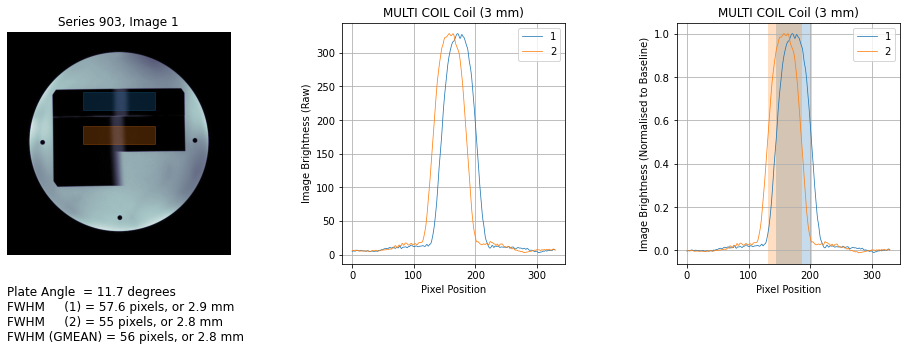

In [5]:
# TO2: Slice 3mm
info = tests['SliceProfile_PIQT']
patid, studyid = info['PatID'], info['StudyID']
series, slice_idx = info['Series']['3mm'], info['Slice']['3mm']

# Distortion Corrected, Phase RL, Non-Uniformity Corrected 512*512
dobj = fetch_series(patid, studyid, sernos=series, imagesonly=True)[0]
results = slice_profile_report(dobj, frame=slice_idx, phantom=PIQTSP, flipped_ud=False, flipped_rl=False)

### 5 mm Slice

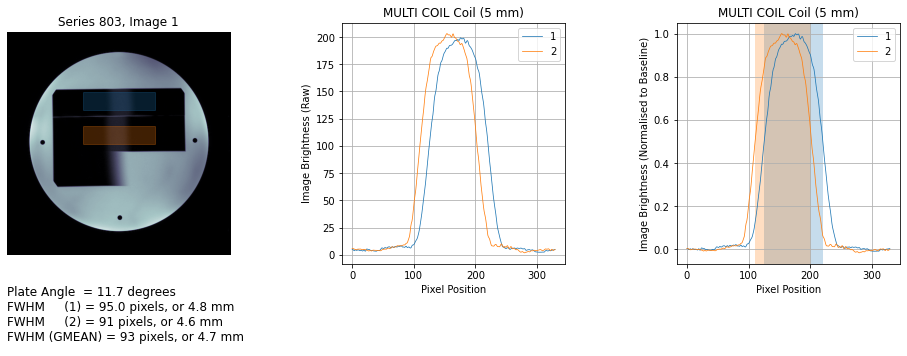

In [6]:
# TO2: Slice 5mm
# Distortion Corrected, Phase RL, Non-Uniformity Corrected 512*512
info = tests['SliceProfile_PIQT']
patid, studyid = info['PatID'], info['StudyID']
series, slice_isx = info['Series']['5mm'], info['Slice']['5mm']

dobj = fetch_series(patid, studyid, sernos=series, imagesonly=True)[0]
result = slice_profile_report(dobj, frame=slice_idx, phantom=PIQTSP, flipped_ud=False, flipped_rl=False)
results = results.append(result)

In [7]:
pd.set_option('precision', 1)
results[['FWHMGMeanPixels', 'FWHMGMeanMM']].rename(columns={
    'FWHMGMeanPixels': 'Projected FWHM (pixels)',
    'FWHMGMeanMM': 'True FWHM (mm)'
})

Projected FWHM (pixels)  True FWHM (mm)
SliceThickness                                         
3.0                                56.4             2.8
5.0                                93.1             4.7

These profile widths are well within the AAPM tolerance of 0.5mm.

In [8]:
NewPage

## Image Scaling and Geometric Distortion

The PIQT phantom has a grid of objects for scale and distortion measurements in plane. The scale reflects the Gradient Sensitivity calibration performed by the manufacturer as part of the system installation. These results are before and after applying Philips 2D distortion correction.

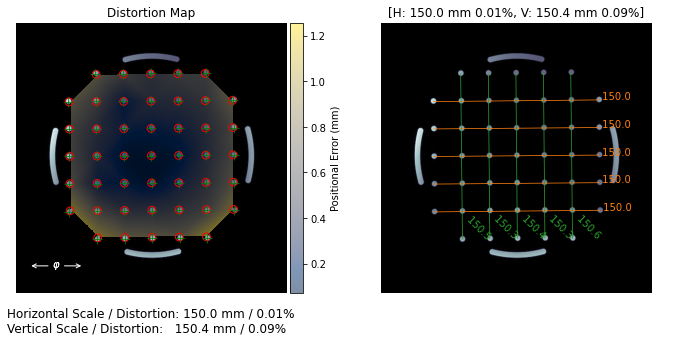

In [9]:
# PIQT: Distortion : SE Axial, Phase RL, 512 matrix (Uncorrected)
info = tests['Distortion_PIQT']
patid, studyid = info['PatID'], info['StudyID']
series, slices = info['Series'], info['Slice']

seriesno, frame = series['AxialRL_Uncorrected'], slices['AxialRL_Uncorrected']
dobj = fetch_series(patid, studyid, sernos=seriesno, imagesonly=True)[0]
results = piqt_distortion_report(dobj, frame=frame)

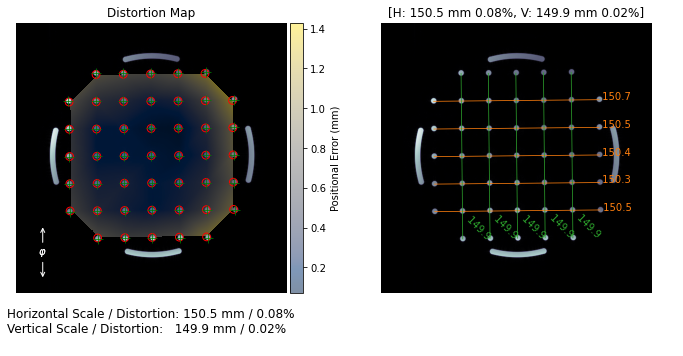

In [10]:
# PIQT: Distortion : SE Axial, Phase AP, 512 matrix (Uncorrected)
seriesno, frame = series['AxialAP_Uncorrected'], slices['AxialAP_Uncorrected']
dobj = fetch_series(patid, studyid, sernos=seriesno, imagesonly=True)[0]
results = results.append(piqt_distortion_report(dobj, frame=frame))

In [11]:
pd.set_option('precision', 3)
results[[
    'Orientation', 'PhaseDirection', 'Sensitivity',
    'HorizontalScale', 'HorizontalDistortion',
    'VerticalScale', 'VerticalDistortion'
]].rename(columns={
    'PhaseDirection': 'Phase Direction',
    'HorizontalScale': 'Horizontal Scale (mm)', 'HorizontalDistortion':'Horizontal Distortion',
    'VerticalScale': 'Vertical Scale (mm)', 'VerticalDistortion': 'Vertical Distortion'  
})

Orientation Phase Direction  Sensitivity  Horizontal Scale (mm)  \
Series                                                                   
904          Axial              RL        0.238                150.018   
1004         Axial              AP        0.238                150.474   

        Horizontal Distortion  Vertical Scale (mm)  Vertical Distortion  
Series                                                                   
904                     0.011              150.438                0.087  
1004                    0.080              149.897                0.020

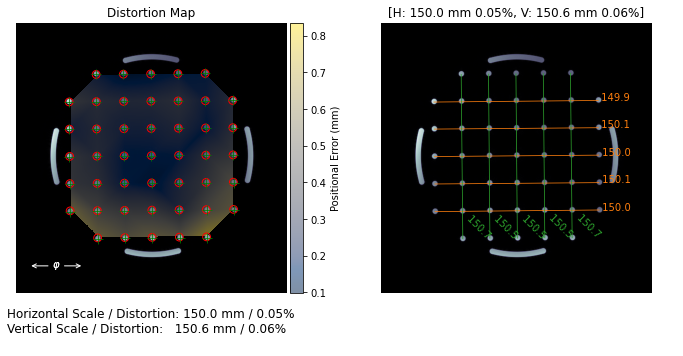

In [12]:
# PIQT: Distortion : SE Axial, Phase RL, 512 matrix (Corrected)
seriesno, frame = series['AxialRL_Corrected'], slices['AxialRL_Corrected']
dobj = fetch_series(patid, studyid, sernos=seriesno, imagesonly=True)[0]
results = piqt_distortion_report(dobj, frame=frame)

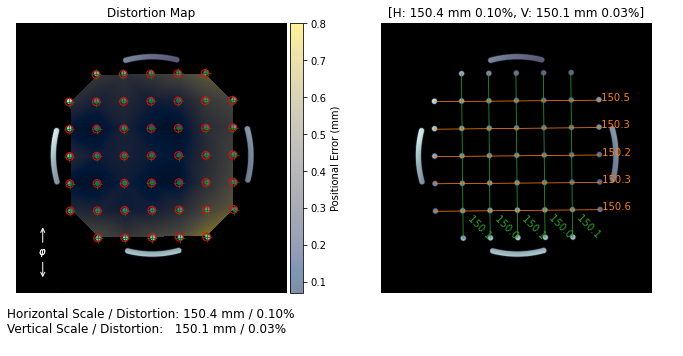

In [13]:
# PIQT: Distortion : SE Axial, Phase AP, 512 matrix (Corrected)
seriesno, frame = series['AxialAP_Corrected'], slices['AxialAP_Corrected']
dobj = fetch_series(patid, studyid, sernos=seriesno, imagesonly=True)[0]
results = results.append(piqt_distortion_report(dobj, frame=frame))

In [14]:
pd.set_option('precision', 3)
results[[
    'Orientation', 'PhaseDirection', 'Sensitivity',
    'HorizontalScale', 'HorizontalDistortion',
    'VerticalScale', 'VerticalDistortion'
]].rename(columns={
    'PhaseDirection': 'Phase Direction',
    'HorizontalScale': 'Horizontal Scale (mm)', 'HorizontalDistortion':'Horizontal Distortion',
    'VerticalScale': 'Vertical Scale (mm)', 'VerticalDistortion': 'Vertical Distortion'  
})

Orientation Phase Direction  Sensitivity  Horizontal Scale (mm)  \
Series                                                                   
903          Axial              RL        0.238                150.034   
1003         Axial              AP        0.238                150.382   

        Horizontal Distortion  Vertical Scale (mm)  Vertical Distortion  
Series                                                                   
903                     0.047              150.587                0.056  
1003                    0.103              150.062                0.034

The scale in both the RL and AP directions are well within 1% at the bandwidth used (260Hz/pixel).

In [15]:
NewPage

## Resolution

Image resolution is estimated by analysis of the MTF block in the PIQT phantom.

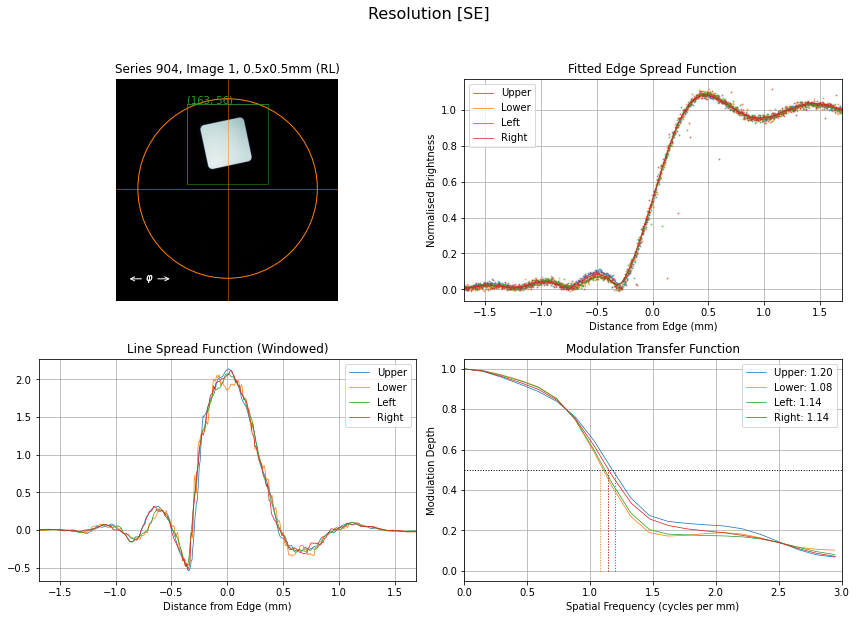

MTF_50
Upper   1.202
Lower   1.082
Left    1.142
Right   1.145

In [16]:
# PIQT: Resolution/MTF
info = tests['Resolution_PIQT']
patid, studyid = info['PatID'], info['StudyID']
series, slices = info['Series'], info['Slice']

# SE: Axial, Phase RL, 512 matrix
dobjs = sorted(fetch_series(patid, studyid, sernos=[series['SE512']], imagesonly=True), key=lambda d: int(d.InstanceNumber))
if len(dobjs) > 1: #accommodate multiframes
    dobj_mtf, dobj_centre = dobjs[slices['MTF']], dobjs[slices['Centre']]
    results = mtf_report(dobj_mtf, dobj_centre)
else:
    results = mtf_report(dobjs[0], mtf_frame=slices['MTF'], centring_frame=slices['Centre'])
plt.show()
results

The MTF_50 is consistent with an image resolution of 0.5mm x 0.5mm as is the case here with a `512*512` acquisition.

In [17]:
NewPage

## Ghosting

Image ghosting is assessed following the approach of [AAPM report 100](https://www.aapm.org/pubs/reports/RPT_100.pdf) for the transverse orientation and four example sequences.

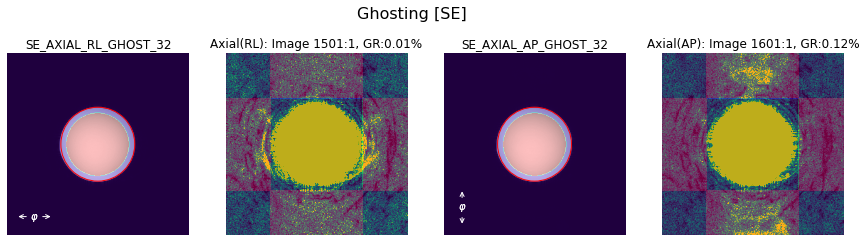

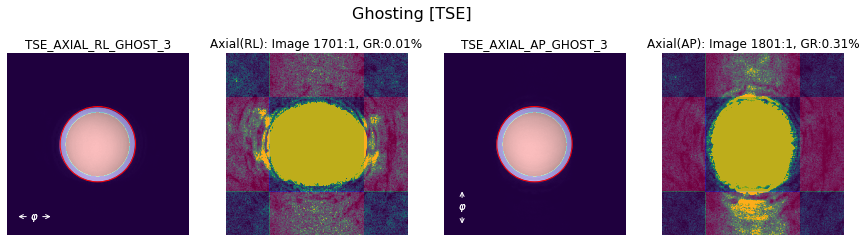

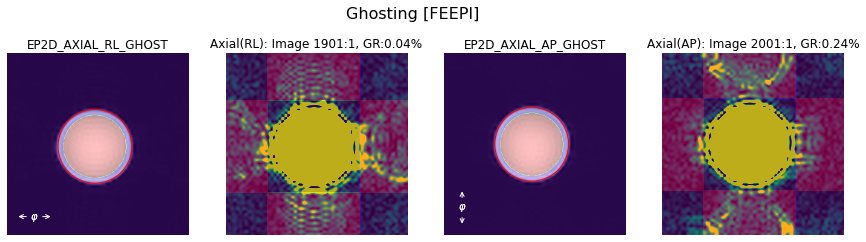

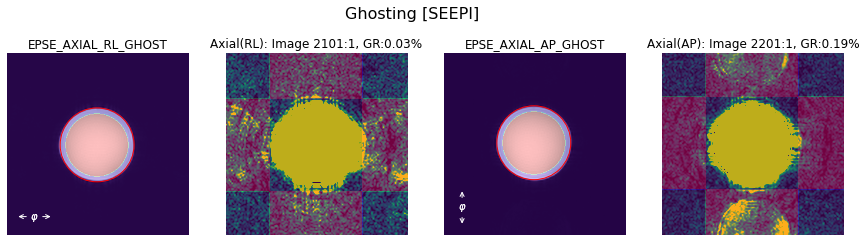

Sequence Orientation Phase Direction  Ghost Ratio (%)
Series                                                      
1501         SE       Axial              RL            0.009
1601         SE       Axial              AP            0.118
1701        TSE       Axial              RL            0.014
1801        TSE       Axial              AP            0.314
1901      FEEPI       Axial              RL            0.042
2001      FEEPI       Axial              AP            0.237
2101      SEEPI       Axial              RL            0.035
2201      SEEPI       Axial              AP            0.194

In [18]:
# GE10CM: Ghosting
info = tests['Ghosting_GE10']
patid, stuid = info['PatID'], info['StudyID']
series = info['Series']

# SE Axial
dobjs = [fetch_series(patid, stuid, sernos=[serno], imagesonly=True)[0] for serno in series['SE']]
_, axs = plt.subplots(1, 4, figsize=(15, 4))
results = ghosting_report(dobjs, axes=list(axs.flat))

# TSE18 Axial
dobjs = [fetch_series(patid, stuid, sernos=[serno], imagesonly=True)[0] for serno in series['TSE']]
_, axs = plt.subplots(1, 4, figsize=(15, 4))
results = results.append(ghosting_report(dobjs, axes=list(axs.flat)))

# EPI64 Axial
dobjs = [fetch_series(patid, stuid, sernos=[serno], imagesonly=True)[0] for serno in series['EP2D']]
_, axs = plt.subplots(1, 4, figsize=(15, 4))
results = results.append(ghosting_report(dobjs, axes=list(axs.flat)))
plt.show()

# EPISE128 Axial
dobjs = [fetch_series(patid, stuid, sernos=[serno], imagesonly=True)[0] for serno in series['EPSE']]
_, axs = plt.subplots(1, 4, figsize=(15, 4))
results = results.append(ghosting_report(dobjs, axes=list(axs.flat)))
plt.show()

with pd.option_context('display.precision', 3):
    display(
        results[['Sequence', 'Orientation', 'PhaseDirection', 'GhostRatio']].rename(columns={
            'PhaseDirection': 'Phase Direction', 'GhostRatio': 'Ghost Ratio (%)'
        })
    )

The level of ghosting is under 1% for all sequences measured here including the EPIs. The TSE AP is a little worse than might be expected for this sequence as was the case on the previous annual.

In [19]:
NewPage

## Receiver Coil Uniformity

We have tested the uniformity of the 32 Channel head coil using a spherical phantom filled with silicone oil. Results are presented both before and after `CLEAR` intensity correction.

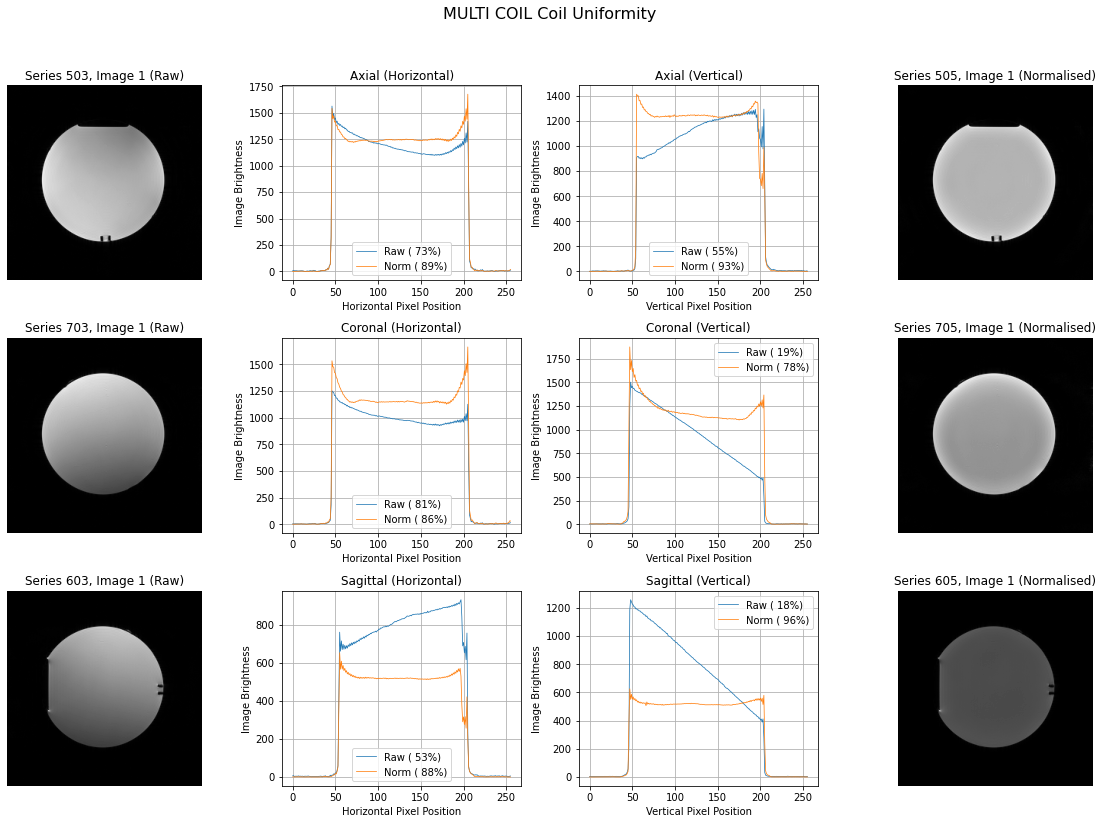

Raw Images


Series No.                              Protocol         Axis  \
Orientation                                                                  
Axial               503  SE_AXIAL_RL_UNIF_OILSPHERE_32CH_NONE     Axial/RL   
Coronal             703    SE_COR_RL_UNIF_OILSPHERE_32CH_NONE   Coronal/RL   
Sagittal            603    SE_SAG_AP_UNIF_OILSPHERE_32CH_NONE  Sagittal/AP   

              X Uniformity (%)  Y Uniformity (%)  
Orientation                                       
Axial                    72.84             54.97  
Coronal                  80.75             18.99  
Sagittal                 53.29             18.24

Intensity Normalised Images


Series No.                               Protocol         Axis  \
Orientation                                                                   
Axial               505  SE_AXIAL_RL_UNIF_OILSPHERE_32CH_CLEAR     Axial/RL   
Coronal             705    SE_COR_RL_UNIF_OILSPHERE_32CH_CLEAR   Coronal/RL   
Sagittal            605    SE_SAG_AP_UNIF_OILSPHERE_32CH_CLEAR  Sagittal/AP   

              X Uniformity (%)  Y Uniformity (%)  
Orientation                                       
Axial                    88.89             92.72  
Coronal                  85.71             77.50  
Sagittal                 88.16             96.25

In [20]:
# OILSPHERE: Uniformity
# SE Axial,Coronal,Sagittal; w w/o Intensity Normalization
info = tests['Uniformity_Oil']
patid, stuid = info['PatID'], info['StudyID']
series = info['Series']

raw_tra = fetch_series(patid, stuid, sernos=series['Axial'][0], imagesonly=True)
psn_tra = fetch_series(patid, stuid, sernos=series['Axial'][1], imagesonly=True)
raw_sag = fetch_series(patid, stuid, sernos=series['Sagittal'][0], imagesonly=True)
psn_sag = fetch_series(patid, stuid, sernos=series['Sagittal'][1], imagesonly=True)
raw_cor = fetch_series(patid, stuid, sernos=series['Coronal'][0], imagesonly=True)
psn_cor = fetch_series(patid, stuid, sernos=series['Coronal'][1], imagesonly=True)

if len(raw_tra) > 1:
    results = uniformity_report(
        raw_dobjs=[raw_tra[0], raw_sag[0], raw_cor[0]],
        psn_dobjs=[psn_tra[0], psn_sag[0], psn_cor[0]],
        raw_dobjsb=[raw_tra[1], raw_sag[1], raw_cor[1]],
        psn_dobjsb=[psn_tra[1], psn_sag[1], psn_cor[1]]
    )
else:
    results = uniformity_report(
        raw_dobjs=[raw_tra[0], raw_sag[0], raw_cor[0]],
        psn_dobjs=[psn_tra[0], psn_sag[0], psn_cor[0]],
    )

plt.show()

with pd.option_context('display.precision', 2):
    print('Raw Images')
    display(
        results[['SeriesRaw',  'ProtocolRaw',  'OrientRaw', 'XUniformityRaw', 'YUniformityRaw']].rename(columns={
            'SeriesRaw': 'Series No.', 'ProtocolRaw': 'Protocol', 'OrientRaw': 'Axis',
            'XUniformityRaw': ' X Uniformity (%)', 'YUniformityRaw': 'Y Uniformity (%)'
        })
    )
    print('Intensity Normalised Images')
    display(
        results[['SeriesNorm', 'ProtocolNorm', 'OrientNorm', 'XUniformityNorm', 'YUniformityNorm']].rename(columns={
            'SeriesNorm': 'Series No.', 'ProtocolNorm': 'Protocol', 'OrientNorm': 'Axis',
            'XUniformityNorm': ' X Uniformity (%)', 'YUniformityNorm': 'Y Uniformity (%)'
        })
    )

As expected for a multi-element coil the uncorrected images are significantly non-uniform. However, the Philips `CLEAR` intensity correction is adequate in compensating for this. The Head-Foot axis in the coronal plane has the highest residual non-uniformity.

In [21]:
NewPage

## Signal to Noise

For reference purposes the following is an independent estimate for a head coil using the Philips 2L bottle phantom. The SNR is estimated over centred discs with diameters 50% and 75% of the phantom. The signal is taken from a region within the phantom in the mean of two images and the noise is estimated from a background region in their difference image.

### High Density Head Coil

#### Single-element Images
This is the SNR calculated from individual element images combined as a sum of squares. This is the methodology used in the quarterly QA.

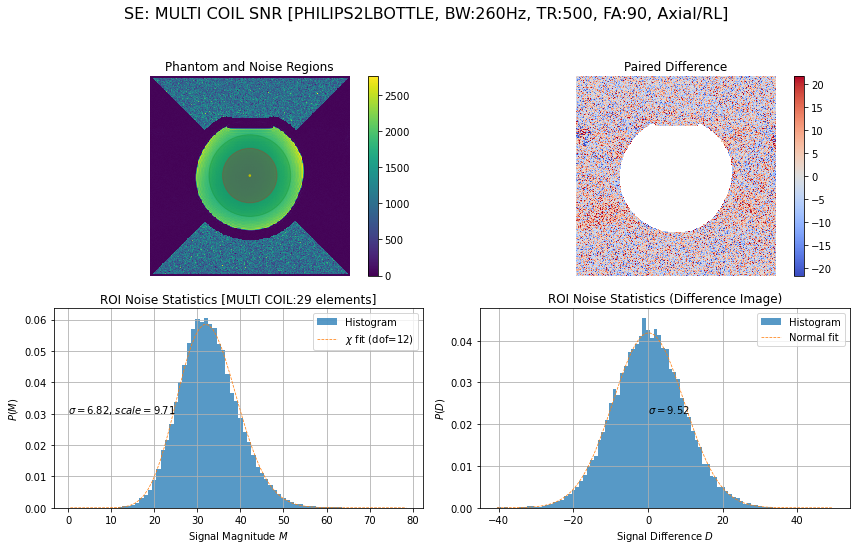

MULTI COIL
0.50      226.56
0.75      243.92

In [22]:
# SNR (uncombined channels)
info = tests['QuarterlySNR_32']
patid, stuid = info['PatID'], info['StudyID']
series = info['Series']

dobjs = fetch_series(patid, stuid, series['Signal'], imagesonly=True)
assert len(dobjs) == 1
results = snr_report_multi(dobjs, phantom=PHILIPS2LBOTTLE)
plt.show()

with pd.option_context('display.precision', 2):
    display(results)

The noise distribution and SNR values are acceptable.

In [23]:
NewPage

## Long Term Stability
The long term stability of an EPI acquisition over a period of 20 minutes. This was performed on a spherical gel filled phantom.

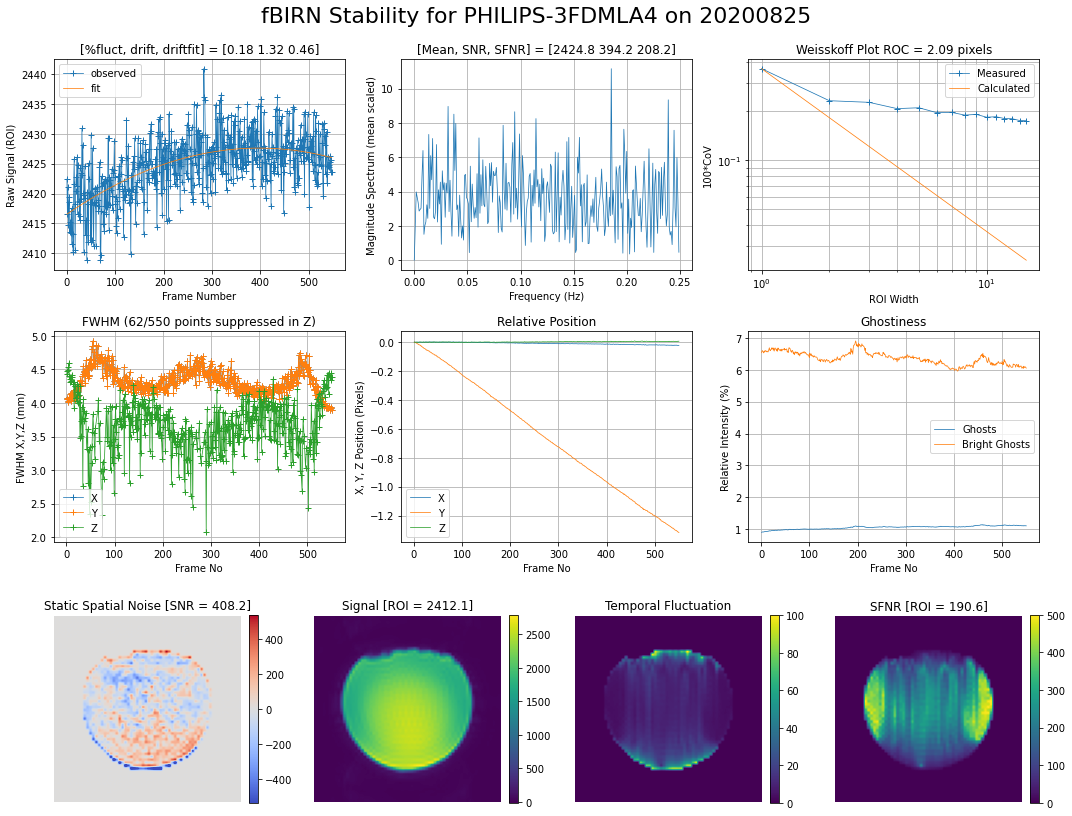

Fluctuations  FittedDrift  Ghosts  BrightGhosts  \
PHILIPS-3FDMLA4_20200825         0.176        0.457   1.056          6.36   

                          SignalMean     SNR     SFNR  
PHILIPS-3FDMLA4_20200825    2424.783  394.25  208.177

In [24]:
# FBIRN Spherical Phantom: Long Term stability
info = tests['Stability']
patid, studyid = info['PatID'], info['StudyID']
series = info['Series']

dobjs = fetch_series(patid, studyid, sernos=series['Long_20min'], imagesonly=True)
results = fbirn_full_report(dobjs, maxtimes=550, correct_drift=True)
plt.show()
results

We have excluded some variation right at the end of the run and compensated for the significant frequency drift in the images. The signal now shows good overall stability and low (and systematic) drift. However, there is considerable unexplained structure in the Temporal Fluctuation and SFNR images. There are no particularly strong frequency components of concern. Weiskoff analysis shows a very small ROC but this is not concerning in isolation. The positional/frequency drift is significant (1.2mm) but evolves steadily. Ghosting levels are moderate and reasonably stable.

In [25]:
NewPage

### Frequency Reference
This is the reference value reported in the DICOM header of a localizer scan.

In [26]:
info = tests['TuneupParams']
patid, studyid = info['PatID'], info['StudyID']
series = info['Series']
dobj = fetch_series(patid, studyid, sernos=series)[0]
pd.DataFrame({
    'ImagingFrequency': [larmor_frequency(dobj)]
}, index=['Value']).T

Value
ImagingFrequency  127.751